In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import shapely

import os
import sys

sys.path.append("../scripts")
from data import SmallPatchesDataset
from models import AutoEncoder, DEC

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# get blocks for 5 largest cities
blocks_df = gpd.read_file("../data/census_blocks_patches.geojson")
biggest_blocks = blocks_df.groupby(["state", "county"]).agg("count").reset_index().iloc[:, 0:3].sort_values("tract", ascending = False).head(1)
blocks_df = blocks_df[(blocks_df.state.isin(biggest_blocks.state) & blocks_df.county.isin(biggest_blocks.county))]

In [3]:
# cleaning blocks based in economic variables
blocks_df = blocks_df[blocks_df.mhi > 0]
blocks_df = blocks_df.dropna()

# remove patches that are have small intersection with block
intersection_threshold = 0.75

def remove_patches(relation):
    relation_list = relation.strip(' ').split(' ')
    relation_list = [x for x in relation_list if x != "" and float(x.split(";")[1]) > intersection_threshold]
    if len(relation_list) == 0:
        return ""
    return " ".join(relation_list)
blocks_df["patches_relation"] = blocks_df.patches_relation.apply(remove_patches)

# drop blocks without patches

blocks_df["area_km2"] = blocks_df['geometry'].to_crs({'proj':'cea'}).area / 10**6
blocks_df["density"] = blocks_df["pop"] / blocks_df["area_km2"]
blocks_df = blocks_df[~(blocks_df.patches_relation == "")]

blocks_df["n_patches"] = blocks_df.patches_relation.apply(lambda x : len(x.strip(" ").split(" ")))
blocks_df["intersection_ratio"] = blocks_df.patches_relation.apply(lambda x : ([float(x_.split(";")[1]) for x_ in x.split(" ") if x_ != ""]))
blocks_df["min_intersection_ratio"] = blocks_df["intersection_ratio"].apply(lambda x : np.min(x))
blocks_df["max_intersection_ratio"] = blocks_df["intersection_ratio"].apply(lambda x : np.max(x))
blocks_df["mean_intersection_ratio"] = blocks_df["intersection_ratio"].apply(lambda x : np.mean(x))

In [4]:
blocks_df = blocks_df.reset_index(drop = True)

In [5]:
patches_blocks = {}
for i, row in tqdm(blocks_df.iterrows(), total = blocks_df.shape[0]):
    relation_list = row["patches_relation"].strip(" ").split(" ")
    relation_list = [x.split(";") for x in relation_list]
    relation_list = [x[0] for x in relation_list if float(x[1]) > intersection_threshold]
    for file in relation_list:
        if file in patches_blocks.keys():
            patches_blocks[file].append(i)
        else:
            patches_blocks[file] = [i]
print(len(patches_blocks.keys()))

  0%|          | 0/4017 [00:00<?, ?it/s]

100%|██████████| 4017/4017 [00:00<00:00, 33125.56it/s]

79172


In [6]:
k = 20
latent_dim = 100
model_autoencoder = AutoEncoder(latent_dim, encoder_arch= "resnet50", decoder_layers_per_block = [3] * 5)
encoder = model_autoencoder.encoder
model = DEC(k, latent_dim, encoder)
model.load_state_dict(torch.load(f"../models/DEC_resnet50_clusters_{k}/model.pt"));
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

In [7]:
filenames = list(patches_blocks.keys())
cluster_distribution = []
dataset = SmallPatchesDataset(filenames)
dl = torch.utils.data.DataLoader(dataset, batch_size = 96)
for batch, _ in tqdm(dl):
    batch = batch.to(device)
    batch_size = batch.shape[0]
    z = model(batch).detach().cpu().numpy().reshape(batch_size, -1)
    cluster_distribution.append(z)
cluster_distribution = np.concatenate(cluster_distribution)
clusters = np.argmax(cluster_distribution, axis = 1)

  0%|          | 0/3299 [00:00<?, ?it/s]

/home/giovani/miniconda3/envs/urban_gdp/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 3299/3299 [18:45<00:00,  2.93it/s]


### Some utility functions

In [92]:
pd.merge(x, y, left_index = True, right_index=True)

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_8,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_18,cluster_19,mhi,density,ed_attain
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,112813.0,3088.083500,57.83
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,108704.0,2512.223406,42.96
2,6.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,164231.0,2068.112234,46.33
3,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,82083.0,3455.022295,69.27
4,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,79766.0,4564.012032,66.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,1.0,1.0,0.0,13.0,0.0,11.0,1.0,0.0,5.0,10.0,2.0,0.0,1.0,4.0,0.0,3.0,7.0,109271.0,1852.117019,48.13
4013,0.0,0.0,1.0,5.0,0.0,5.0,1.0,0.0,0.0,4.0,2.0,0.0,1.0,1.0,0.0,3.0,2.0,52024.0,2059.937739,46.65
4014,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,112000.0,4612.890374,39.22
4015,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,111563.0,2753.173239,56.91


In [125]:
def plot_correlation_and_proj(x, y, target):
    df = pd.merge(x, y[[target]], left_index=True, right_index=True)
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (8, 3))
    axs[0].matshow(df.corr(), cmap = "bwr")
    axs[0].set_title("Correlation")

    x_proj = TSNE(n_components=2).fit_transform(StandardScaler().fit_transform(x.values))
    axs[1].scatter(x_proj[:, 0], x_proj[:, 1], c = df[target], cmap = "bwr")
    axs[1].set_title("TSNE projection")

    scaler = StandardScaler()
    x_proj = PCA(n_components=2).fit_transform(scaler.fit_transform(x.values))
    axs[2].scatter(x_proj[:, 0], x_proj[:, 1], c = df[target], cmap = "bwr")
    axs[2].set_title("PCA projection")
    
    plt.suptitle(f"prediction of {target}")
    plt.show()

In [99]:
def eval(clf, x_train, y_train, x_test, y_test):
    mae_train = mean_absolute_error(y_train, clf.predict(x_train))
    r2_train = r2_score(y_train, clf.predict(x_train))
    
    mae_test = mean_absolute_error(y_test, clf.predict(x_test))
    r2_test = r2_score(y_test, clf.predict(x_test))
    summary = f"Train MAE: {mae_train:.3f}\t R²: {r2_train:.3f}\tTest MAE: {mae_test:.3f}\t R²: {r2_test:.3f}"
    print(summary)

In [100]:
def grid_search_svm(x_train, y_train, x_test, y_test, rescale = True):
    if rescale:
        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train_ = scaler.transform(x_train).copy()
        x_test_ = scaler.transform(x_test).copy()
    else:
        x_train_ = x_train.copy()
        x_test_ = x_test.copy()


    svr = SVR()
    parameters = {
        "kernel": ["linear", "rbf"],
        "C": [0.1, 1, 10, 100],
        "gamma": [0.1, 1, 10, 100]
    }
    clf = GridSearchCV(svr, parameters)
    clf.fit(x_train_, y_train)
    eval(clf, x_train_, y_train, x_test_, y_test)

In [102]:
def grid_search_rf(x_train, y_train, x_test, y_test):
    rf = RandomForestRegressor()
    parameters = {
        "n_estimators": [10, 100, 1000],
        "max_depth": [None, 10, 100],
        "min_samples_split": [2, 10, 100],
    }
    clf = GridSearchCV(rf, parameters)
    clf.fit(x_train, y_train)
    eval(clf, x_train, y_train, x_test, y_test)

## Sum of patches in each cluster

In [126]:
x_blocks = np.zeros((blocks_df.shape[0], k))
for i, (file, cluster) in enumerate(zip(filenames, clusters)):
    for b in patches_blocks[file]:
        x_blocks[b, cluster] += 1
for i in range(k):
    blocks_df[f"cluster_{i}"] = x_blocks[:, i]
x = blocks_df[[f"cluster_{i}" for i in range(k)]]
x = x.loc[:, x.sum(axis = 0) > 0]
y = blocks_df[["mhi", "density", "ed_attain"]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

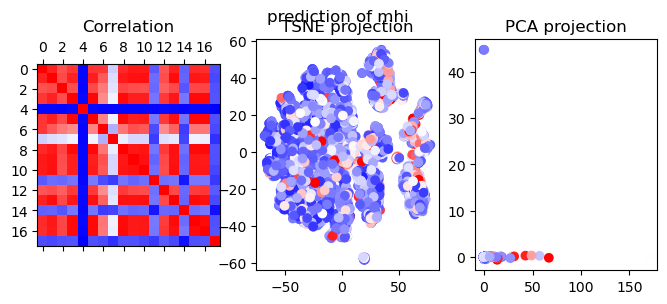

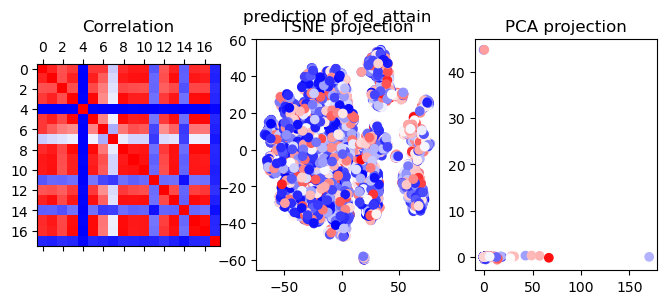

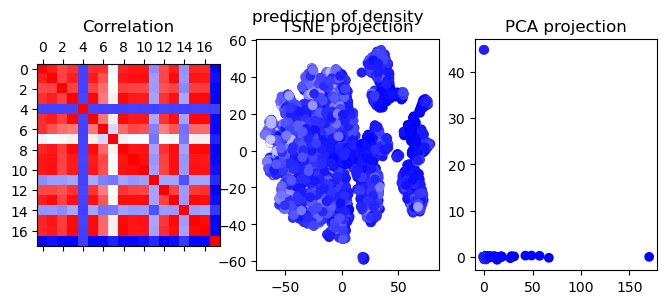

In [127]:
for column in ["mhi", "ed_attain", "density"]:
    plot_correlation_and_proj(x, y, column)

In [98]:
for column in ["mhi", "ed_attain", "density"]:
    print(f"Models for {column}")
    print("SVM")
    grid_search_svm(x_train, y_train[[column]].values.reshape(-1), x_test, y_test[[column]].values.reshape(-1), True)
    print("RF")
    grid_search_rf(x_train, y_train[[column]].values.reshape(-1), x_test, y_test[[column]].values.reshape(-1))

Models for mhi
Train
MAE: 30478.298	 R²: 0.020
Test
MAE: 27997.989	 R²: 0.001
Train
MAE: 27843.395	 R²: 0.283
Test
MAE: 27758.612	 R²: 0.115
Models for ed_attain
Train
MAE: 19.318	 R²: 0.028
Test
MAE: 20.187	 R²: -0.052
Train
MAE: 19.045	 R²: 0.121
Test
MAE: 20.131	 R²: 0.011
Models for density
Train
MAE: 2581.200	 R²: 0.319
Test
MAE: 2569.461	 R²: 0.323
Train
MAE: 2030.231	 R²: 0.595
Test
MAE: 2602.165	 R²: 0.384


## Fraction of patches in each cluster

In [128]:
x_blocks = np.zeros((blocks_df.shape[0], k))
for i, (file, cluster) in enumerate(zip(filenames, clusters)):
    for b in patches_blocks[file]:
        x_blocks[b, cluster] += 1
x_sum = x_blocks.sum(axis = 1)
x_blocks = x_blocks / x_sum[:, None]
for i in range(k):
    blocks_df[f"cluster_{i}"] = x_blocks[:, i]
x = blocks_df[[f"cluster_{i}" for i in range(k)] + ["n_patches"]]
x = x.loc[:, x.sum(axis = 0) > 0]
y = blocks_df[["mhi", "density", "ed_attain"]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

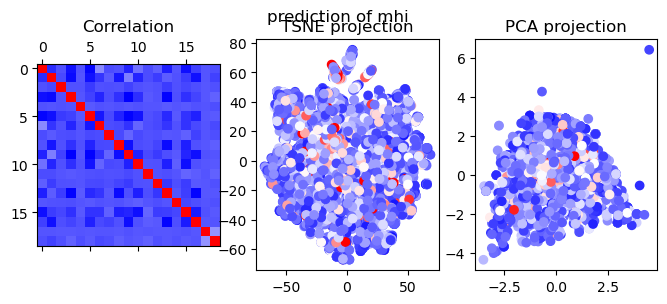

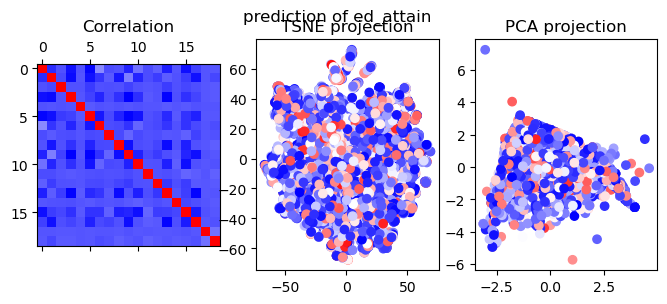

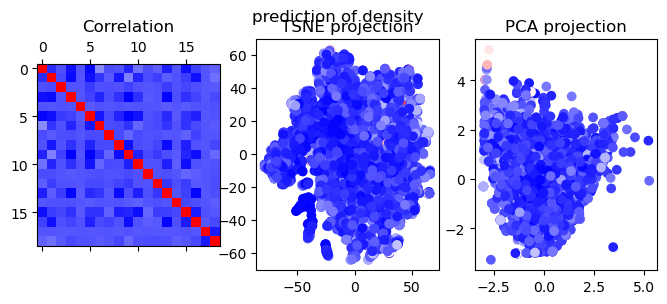

In [129]:
for column in ["mhi", "ed_attain", "density"]:
    plot_correlation_and_proj(x, y, column)

In [105]:
for column in ["mhi", "ed_attain", "density"]:
    print(f"Models for {column}")
    print("SVR")
    grid_search_svm(x_train, y_train[[column]].values.reshape(-1), x_test, y_test[[column]].values.reshape(-1), True)
    print("RF")
    grid_search_rf(x_train, y_train[[column]].values.reshape(-1), x_test, y_test[[column]].values.reshape(-1))

Models for mhi
SVR
Train MAE: 30945.694	 R²: -0.001	Test MAE: 29829.972	 R²: -0.609
RF
Train MAE: 27627.199	 R²: 0.299	Test MAE: 27673.884	 R²: 0.117
Models for ed_attain
SVR
Train MAE: 19.270	 R²: 0.037	Test MAE: 20.322	 R²: -0.039
RF
Train MAE: 18.650	 R²: 0.155	Test MAE: 19.985	 R²: 0.018
Models for density
SVR
Train MAE: 2795.752	 R²: 0.226	Test MAE: 2778.466	 R²: 0.218
RF
Train MAE: 2332.925	 R²: 0.521	Test MAE: 2491.064	 R²: 0.414


## Probability of being in cluster

In [130]:
x_blocks = np.zeros((blocks_df.shape[0], k))
for i, (file, distribution) in enumerate(zip(filenames, cluster_distribution)):
    for b in patches_blocks[file]:
        x_blocks[b, :] += distribution
x_sum = blocks_df.n_patches.values.reshape(-1)
x_blocks = x_blocks / x_sum[:, None]
for i in range(k):
    blocks_df[f"cluster_{i}"] = x_blocks[:, i]
x = blocks_df[[f"cluster_{i}" for i in range(k)] + ["n_patches"]]
x = x.loc[:, x.sum(axis = 0) > 0]
y = blocks_df[["mhi", "density", "ed_attain"]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

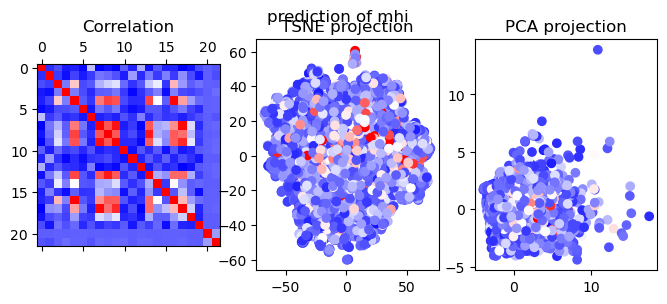

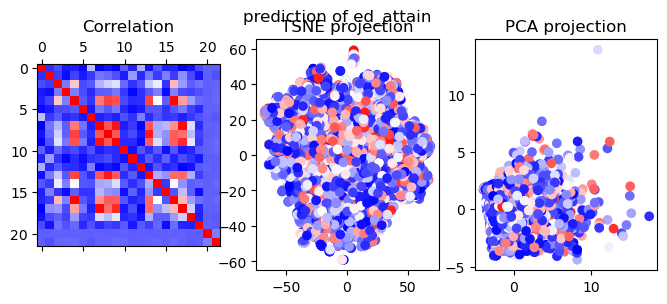

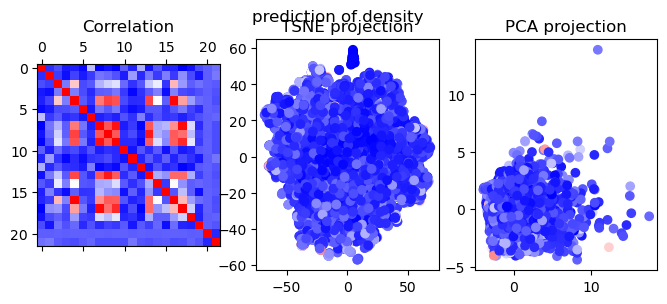

In [131]:
for column in ["mhi", "ed_attain", "density"]:
    plot_correlation_and_proj(x, y, column)

In [132]:
for column in ["mhi", "ed_attain", "density"]:
    print(f"Models for {column}")
    print("SVR")
    grid_search_svm(x_train, y_train[[column]].values.reshape(-1), x_test, y_test[[column]].values.reshape(-1), True)
    print("RF")
    grid_search_rf(x_train, y_train[[column]].values.reshape(-1), x_test, y_test[[column]].values.reshape(-1))

Models for mhi
SVR
Train MAE: 30896.199	 R²: -0.001	Test MAE: 29958.390	 R²: -0.609
RF
